In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import descwl
import galsim
import argparse
import time
import astropy.table

Set up things

In [3]:
parser = argparse.ArgumentParser()
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
analysis_group = parser.add_argument_group('Analysis options',
    'Specify analysis options')
descwl.analysis.OverlapAnalyzer.add_args(analysis_group)
survey_group = parser.add_argument_group('Survey parameters',
    'Specify survey camera and observing parameters.')
descwl.survey.Survey.add_args(survey_group)
render_group = parser.add_argument_group('Model rendering options',
    'Specify options for rendering models as simulated survey observations.')
descwl.render.Engine.add_args(render_group)
model_group = parser.add_argument_group('Source model options',
    'Specify options for building source models from catalog parameters.')
descwl.model.GalaxyBuilder.add_args(model_group)
survey_name = 'LSST'
filter_band = 'r'
args = parser.parse_args(['--survey-name',survey_name,'--filter-band',filter_band])

Create a `Survey` object

In [4]:
survey = descwl.survey.Survey.from_args(args)

Create the render `Engine`

In [5]:
render_engine = descwl.render.Engine(survey,0.05,30,False,False)

Our main function for the analysis

In [6]:
def time_two_galaxies(distance, cosmic_shear_g1, cosmic_shear_g2, 
                      flux_ratio, beta0, beta1, size0, size_ratio,
                      q0, q_ratio, mag0=24, verbose=False, add_noise=False, ftol=1e-2, fixed_position=False,
                      show_stamp=False, add_noise_gauss=False, seed=1):
    dtype=[
            ('db_id',np.int64),
            ('grp_id',np.int64),
            ('grp_size',np.int16),
            ('grp_rank',np.int16),
            ('visible',np.int16),
            # Stamp bounding box.
            ('xmin',np.int32),
            ('xmax',np.int32),
            ('ymin',np.int32),
            ('ymax',np.int32),
            # Source properties.
            ('f_disk', np.float32),
            ('f_bulge', np.float32),
            ('dx',np.float32),
            ('dy',np.float32),
            ('z',np.float32),
            ('ab_mag',np.float32),
            ('ri_color',np.float32),
            ('flux',np.float32),
            ('sigma_m',np.float32),
            ('sigma_p',np.float32),
            ('e1',np.float32),
            ('e2',np.float32),
            ('a',np.float32),
            ('b',np.float32),
            ('beta',np.float32),
            ('psf_sigm',np.float32),
            # Pixel-level properties.
            ('purity',np.float32),
            ('snr_sky',np.float32),
            ('snr_iso',np.float32),
            ('snr_grp',np.float32),
            ('snr_isof',np.float32),
            ('snr_grpf',np.float32),
            ('ds',np.float32),
            ('dg1',np.float32),
            ('dg2',np.float32),
            ('ds_grp',np.float32),
            ('dg1_grp',np.float32),
            ('dg2_grp',np.float32),
            # HSM analysis results.
            ('hsm_sigm',np.float32),
            ('hsm_e1',np.float32),
            ('hsm_e2',np.float32),
            # Systematics fit results.
            ('g1_fit',np.float32),
            ('g2_fit',np.float32),
            ]
    data = np.empty(1, dtype=dtype)
    table = astropy.table.Table(data,copy = False)
    analyzer = descwl.analysis.OverlapAnalyzer(survey,no_hsm=True,no_lmfit=False,add_noise=False)
    total_flux0 = survey.get_flux(mag0)
    mag1 = mag0 - 2.5*np.log10(flux_ratio)
    if flux_ratio<=1:
        total_flux1 = total_flux0*flux_ratio
    else:
        print 'The flux ratio should be <=1!'
    size1=size0*size_ratio
    if verbose:
        print 'Size 0: ', size0
        print 'Size 1: ', size1
    # We are going to consider disk-like galaxies only since they are faster to fit than bulge-like
    bulge_flux = 0.
    agn_flux = 0.
    bulge_hlr_arcsecs=0.
    bulge_q=0.
    # For now we are going to make redshift 0 and not care about the color
    redshift=0
    ri_color=0
    # We put the brightest galaxy in the origin
    dx0=0.0
    dy0=0.0
    id0=0
    id1=1
    if fixed_position:
        dx1 = distance
        dy1 = 0.
    else:
        dx1 = distance*np.random.random()
        dy1 = np.sqrt(distance**2-dx1**2)
    galaxy0 = descwl.model.Galaxy(id0, redshift, mag0, ri_color, 
                                  cosmic_shear_g1, cosmic_shear_g2, 
                                  dx0, dy0, beta0, total_flux0 , size0, q0,
                                  bulge_flux, bulge_hlr_arcsecs, bulge_q, agn_flux)
    stamps0,bounds0 = render_engine.render_galaxy(galaxy0,True,False)
    analyzer.add_galaxy(galaxy0,stamps0,bounds0)
    galaxy1 = descwl.model.Galaxy(id1, redshift, mag1, ri_color, 
                                  cosmic_shear_g1, cosmic_shear_g2, 
                                  dx1, dy1, beta1, total_flux1, size1, q0*q_ratio, 
                                  bulge_flux, bulge_hlr_arcsecs, bulge_q, agn_flux)
    stamps1,bounds1 = render_engine.render_galaxy(galaxy1,True,False)
    analyzer.add_galaxy(galaxy1,stamps1,bounds1)
    results = descwl.analysis.OverlapResults(survey,table,[stamps0,stamps1],[bounds0,bounds1],21)
    subimage = results.get_subimage([id0,id1])
    total_area = subimage.array.shape[0]*subimage.array.shape[1]
    if add_noise:
        generator = galsim.random.BaseDeviate(seed = seed)
        noise = galsim.PoissonNoise(rng = generator, sky_level = survey.mean_sky_level)
        subimage.addNoise(noise)
    if add_noise_gauss and not add_noise:
        generator = galsim.random.BaseDeviate(seed = seed)
        noise = galsim.GaussianNoise(rng = generator, sigma=np.sqrt(survey.mean_sky_level))
        subimage.addNoise(noise)
    if add_noise and add_noise_gauss:
        print 'You activated add Poisson noise and Gaussian noise, I will add only the Poisson noise...'
    if show_stamp:
        plt.imshow(subimage.array,cmap='gray')
    t3 = time.time()
    res = analyzer.fit_galaxies([id0,id1],subimage,ftol=ftol)
    minimum = analyzer.minimum
    t4 = time.time()
    if verbose:
        print 'Time to fit the galaxy ', t4-t3, ' s'
        print total_flux0, total_flux1, minimum.params['df_0'],minimum.params['df_1']
    return t4-t3, total_area, minimum.redchi, minimum.nfev, minimum.params['df_0'].value, minimum.params['df_1'].value

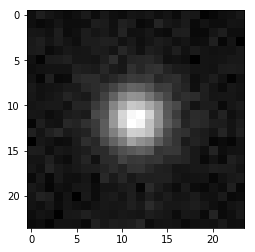

In [7]:
dt, ta, rchi, nev, df0, df1 = time_two_galaxies(0.01,0,0,1,0,0,0.5,0.5,1,1, add_noise=True, show_stamp=True)

In [8]:
def summary_plots(xarr,time_array,size_array,rchi_array,df0_arr,nev_arr,xlabel,xlogscale=False, ylogscale=False):
    fig, ax = plt.subplots(2,2,figsize=(14,14))
    p1 = ax[0,0].scatter(xarr,time_array,marker='.',c=1+df0_arr,label='Disk')
    ax[0,0].set_xlabel(xlabel)
    ax[0,0].set_ylabel('Time to fit (s)')
    ax[0,0].set_ylim(0,1.1*np.max(time_array))
    #ax[0].legend(loc='best')
    ax[0,0].grid()
    plt.colorbar(p1,ax=ax[0,0],label=r'$F_{out}/F_{in}$')
    ax[0,1].plot(xarr,size_array,'.')
    ax[0,1].set_xlabel(xlabel)
    ax[0,1].set_ylabel('Stamp area [pix$^{2}$]')
    ax[0,1].grid()
    #ax[1].legend(loc='best')
    ax[1,0].plot(xarr,rchi_array,'.')
    ax[1,0].set_xlabel(xlabel)
    ax[1,0].set_ylabel(r'$\chi^{2}/ndof$')
    #ax[2].legend(loc='best')
    ax[1,0].grid()
    ax[1,1].plot(xarr,nev_arr,'.')
    ax[1,1].set_xlabel(xlabel)
    ax[1,1].set_ylabel('Number of iterations')
    ax[1,1].grid()
    if xlogscale:
        for i in range(2):
            for j in range(2):
                ax[i,j].set_xscale('log')
    if ylogscale:
        for i in range(2):
            for j in range(2):
                ax[i,j].set_yscale('log')
    plt.tight_layout()

We are going to study two scenarios:
- In one scenario we have the brightest galaxy in the center of the stamp and the second has a second position in a circle of radius=`distance`.
- In the other scenario we put the second galaxy in the x axis at a distance=`distance`.

# Dependence with distance for the same magnitude, size, aspect ratio, and orientation

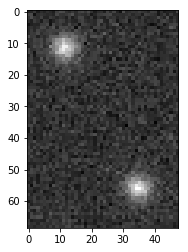

In [9]:
npoints=100
nreps=20
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
nev_arr = np.zeros((npoints,nreps))
df0_arr = np.zeros((npoints,nreps))
df1_arr = np.zeros((npoints,nreps))
distance = np.linspace(0.01,10,100)
show=False
seed = np.arange(npoints*nreps)
for j in range(nreps):
    for i in range(npoints):
        if (j==nreps-1) & (i==npoints-1):
            show=True
        t_arr[i,j], s_arr[i,j], rchi_arr[i,j], nev_arr[i,j], df0_arr[i,j], df1_arr[i,j] = time_two_galaxies(distance[i],0,0,1,0,0,0.5,1,1,1, add_noise=True,show_stamp=show,seed=seed[npoints*j+i])

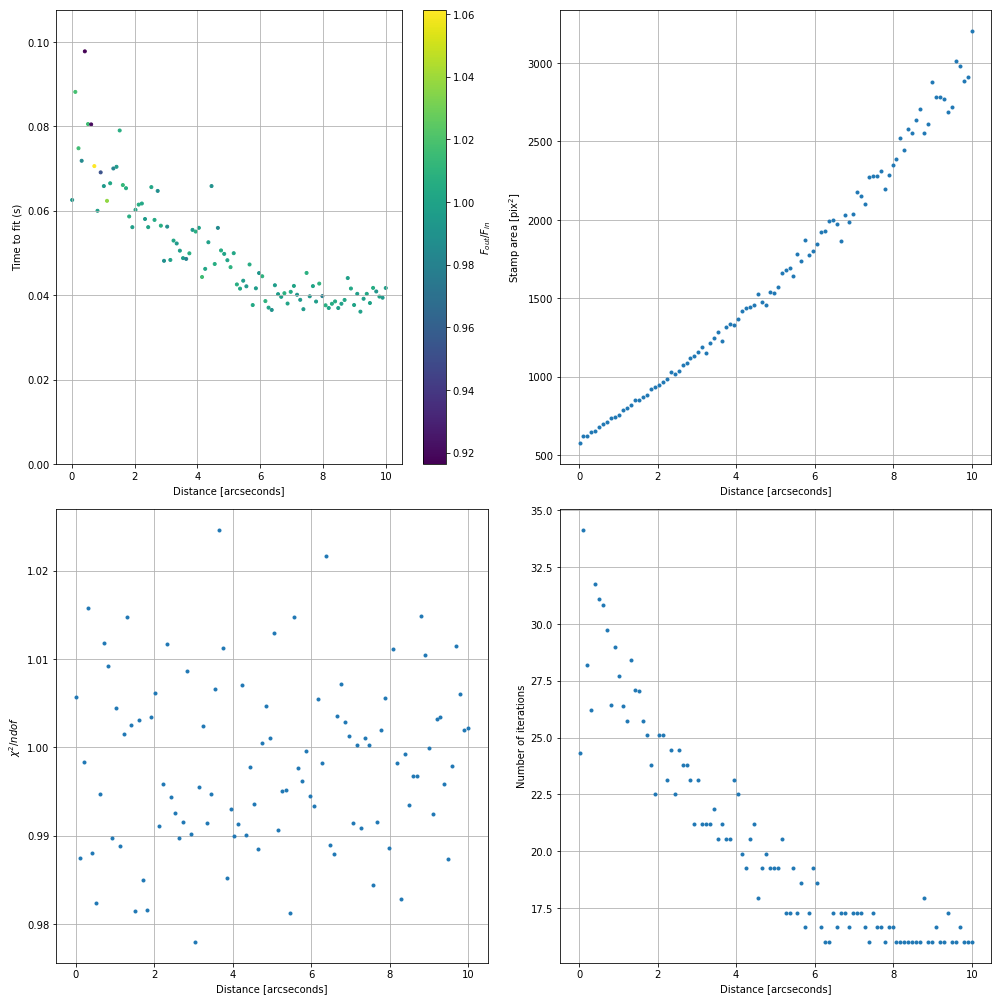

In [10]:
summary_plots(distance, np.mean(t_arr,axis=1), np.mean(s_arr,axis=1), np.mean(rchi_arr,axis=1),np.mean(df0_arr,axis=1),np.mean(nev_arr,axis=1),'Distance [arcseconds]')

In [14]:
npoints=100
nreps=20
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
nev_arr = np.zeros((npoints,nreps))
df0_arr = np.zeros((npoints,nreps))
df1_arr = np.zeros((npoints,nreps))
for j in range(nreps):
    for i in range(npoints):
        t_arr[i,j], s_arr[i,j], rchi_arr[i,j], nev_arr[i,j], df0_arr[i,j], df1_arr[i,j] = time_two_galaxies(distance[i],0,0,1,0,0,0.5,1,1,1, add_noise=True, fixed_position=True, seed=npoints*j+i)

In [15]:
print nev_arr[1,:],np.mean(nev_arr,axis=1)

[ 30.  43.  44.  17.  31.  43.  43.  31.  17.  57.  31.  56.  17.  30.  30.
  44.  31.  43.  43.  31.] [ 26.35  35.6   32.75  27.4   28.5   31.45  33.35  30.45  29.65  29.65
  26.4   27.7   25.75  26.4   25.75  27.05  27.7   25.1   25.1   27.7   25.1
  24.45  27.7   27.05  25.1   23.15  25.1   24.45  23.8   25.75  25.75
  24.45  22.5   23.15  23.8   24.45  24.45  24.45  22.5   25.1   24.45
  22.5   24.45  23.8   22.5   19.9   21.2   23.8   21.85  21.85  22.5
  24.45  21.2   21.85  21.85  19.25  22.5   19.9   21.85  19.25  19.9
  21.85  19.9   19.9   21.85  20.55  19.9   19.9   19.25  21.2   17.95
  22.5   17.95  18.6   19.9   19.9   19.25  18.6   17.3   18.6   18.6   17.3
  20.55  17.95  17.95  19.9   17.95  17.95  19.25  16.65  19.25  17.3   17.3
  17.95  19.25  17.95  18.6   18.6   17.3   18.6 ]


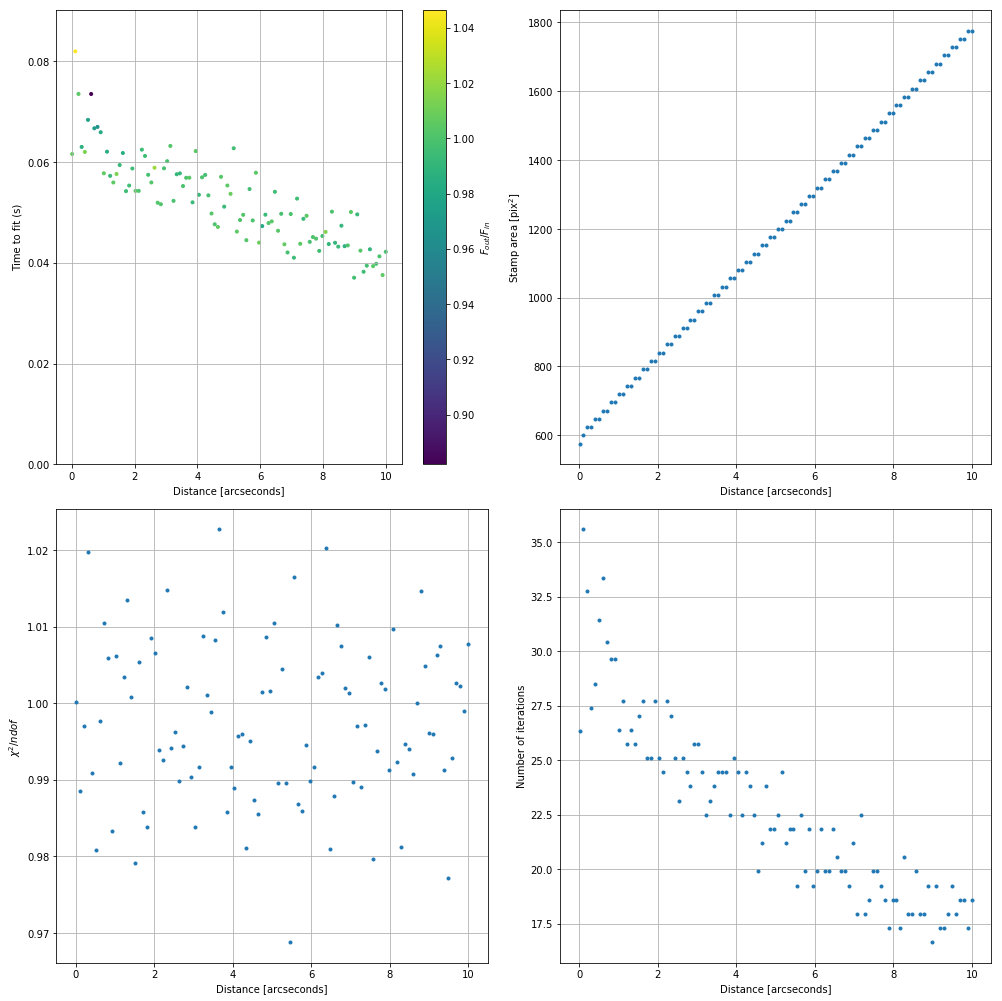

In [16]:
summary_plots(distance[0:nev_arr.shape[0]], np.mean(t_arr,axis=1), np.mean(s_arr,axis=1), np.mean(rchi_arr,axis=1),np.mean(df0_arr,axis=1),np.mean(nev_arr,axis=1),'Distance [arcseconds]')

# Changing $f_{tol}$ to 0.1

In [17]:
npoints=100
nreps=5
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
nev_arr = np.zeros((npoints,nreps))
df0_arr = np.zeros((npoints,nreps))
df1_arr = np.zeros((npoints,nreps))
for j in range(nreps):
    for i in range(npoints):
        t_arr[i,j], s_arr[i,j], rchi_arr[i,j], nev_arr[i,j], df0_arr[i,j], df1_arr[i,j] = time_two_galaxies(distance[i],0,0,1,0,0,0.5,1,1,1, add_noise=True, fixed_position=True,ftol=0.1,seed=npoints*j+i)

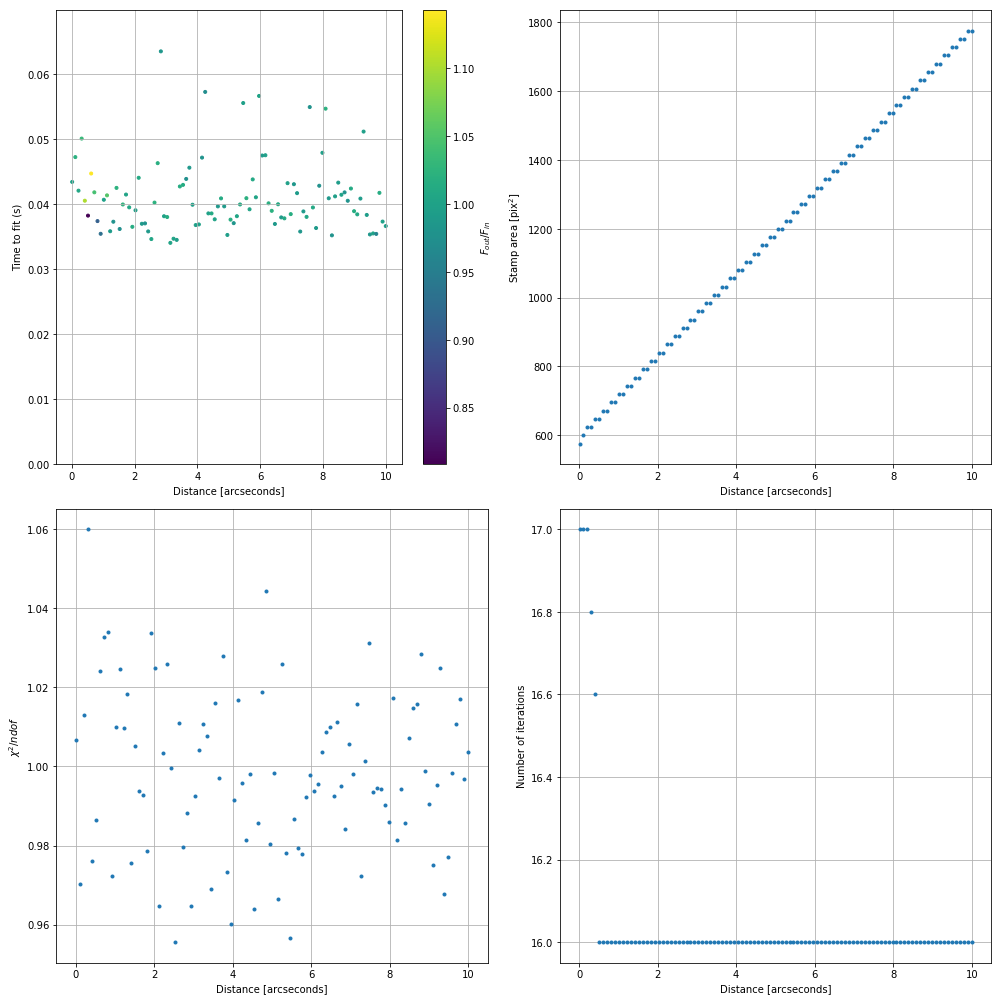

In [18]:
summary_plots(distance, np.mean(t_arr,axis=1), np.mean(s_arr,axis=1), np.mean(rchi_arr,axis=1),np.mean(df0_arr,axis=1),np.mean(nev_arr,axis=1),'Distance [arcseconds]')

# Dependence on the flux ratio (distance = 10", mag$_{0}$ = 19, $\sigma_{-}$= 0.5", circular) 

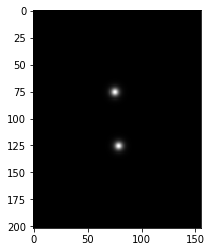

In [19]:
npoints=100
nreps=20
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
nev_arr = np.zeros((npoints,nreps))
df0_arr = np.zeros((npoints,nreps))
df1_arr = np.zeros((npoints,nreps))
flux_ratio = np.logspace(-5,0,npoints)
show=False
for j in range(nreps):
    for i in range(npoints):
        if (j==nreps-1) & (i==npoints-1):
            show=True
        t_arr[i,j], s_arr[i,j], rchi_arr[i,j], nev_arr[i,j], df0_arr[i,j], df1_arr[i,j] = time_two_galaxies(10,0,0,flux_ratio[i],0,0,0.5,1,1,1,mag0=16.0, add_noise=True,show_stamp=show,seed=npoints*j+i)

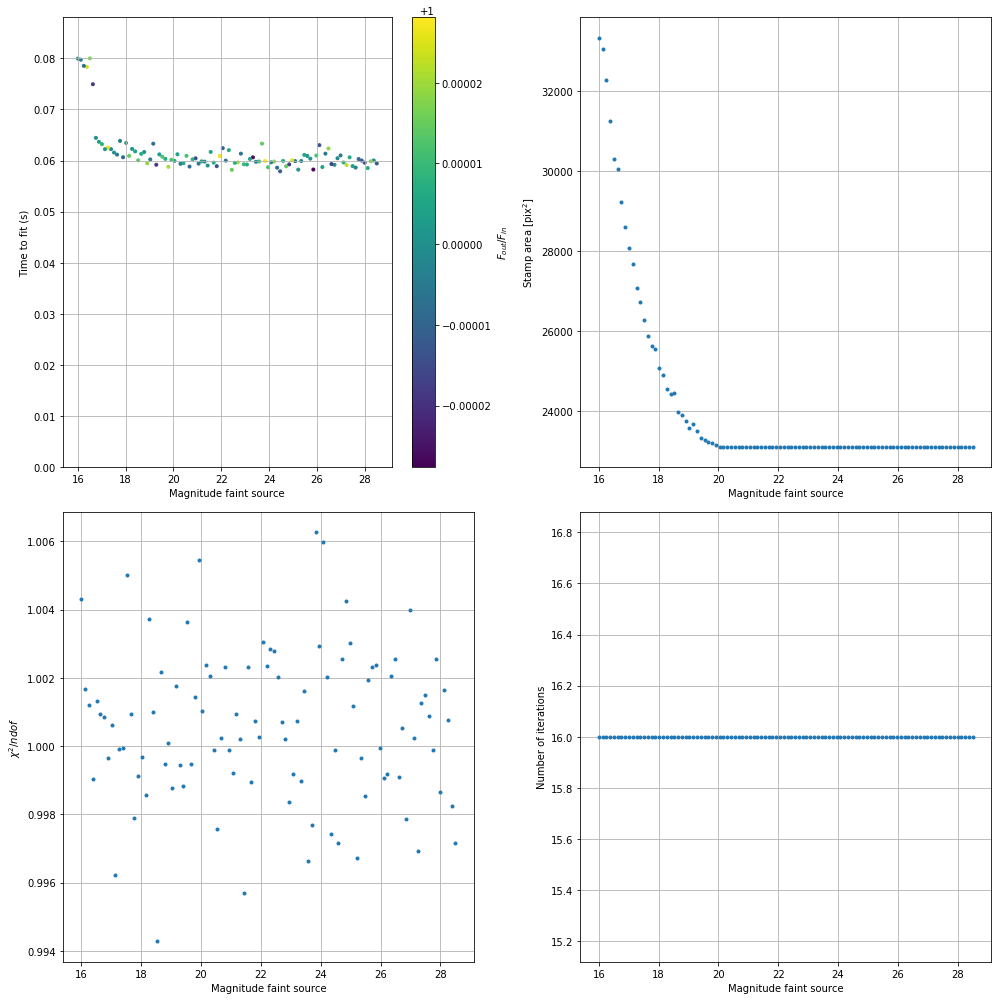

In [20]:
magnitude = 16.0-2.5*np.log10(flux_ratio)
summary_plots(magnitude,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),np.mean(df0_arr,axis=1),np.mean(nev_arr,axis=1),'Magnitude faint source')

# Dependence on the size ratio (distance = 10", mag = 24, $\sigma_{-}$= 1.0", circular) 

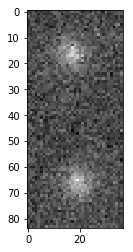

In [21]:
npoints=100
nreps=20
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
nev_arr = np.zeros((npoints,nreps))
df0_arr = np.zeros((npoints,nreps))
df1_arr = np.zeros((npoints,nreps))
size_ratio = np.linspace(0.1,1,npoints)
show=False
for j in range(nreps):
    for i in range(npoints):
        if (j==nreps-1) & (i==npoints-1):
            show=True
        t_arr[i], s_arr[i], rchi_arr[i], nev_arr[i,j], df0_arr[i,j], df1_arr[i,j] = time_two_galaxies(10,0,0,1,0,0,1.,size_ratio[i],1,1,add_noise=True,show_stamp=show,seed=npoints*j+i)

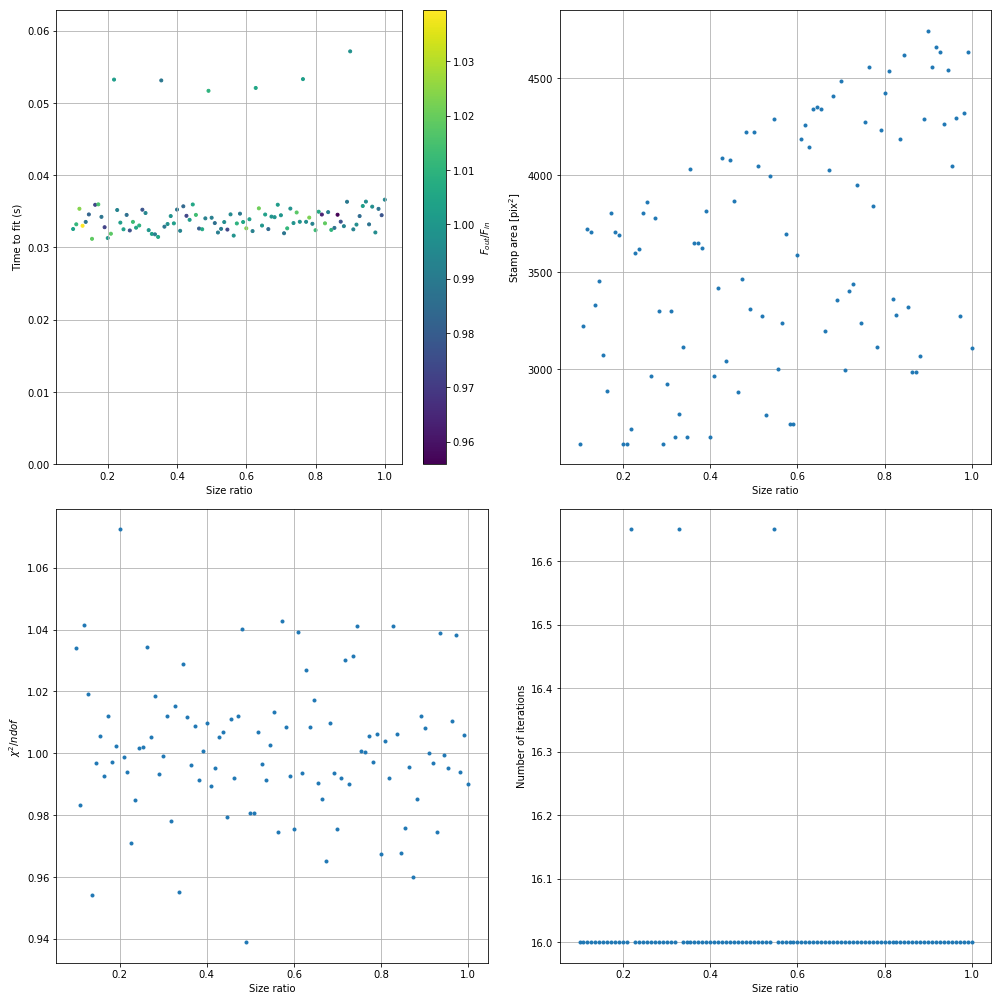

In [22]:
summary_plots(size_ratio,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),np.mean(df0_arr,axis=1),np.mean(nev_arr,axis=1),'Size ratio')

# Dependence on $q$ ratio (distance=10", mag=24, $\sigma_{-}=0.5"$, $q_{0}=1$)

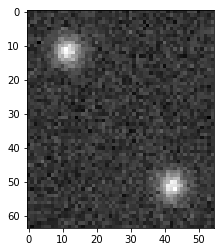

In [23]:
npoints=100
nreps=20
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
nev_arr = np.zeros((npoints,nreps))
df0_arr = np.zeros((npoints,nreps))
df1_arr = np.zeros((npoints,nreps))
q_ratio = np.linspace(0.1,1,npoints)
show=False
for j in range(nreps):
    for i in range(npoints):
        if (j==nreps-1) & (i==npoints-1):
            show=True
        t_arr[i], s_arr[i], rchi_arr[i], nev_arr[i,j], df0_arr[i,j], df1_arr[i,j]  = time_two_galaxies(10,0,0,1,0,0,0.5,1,1,q_ratio[i],add_noise=True,show_stamp=show,seed=npoints*j+i)

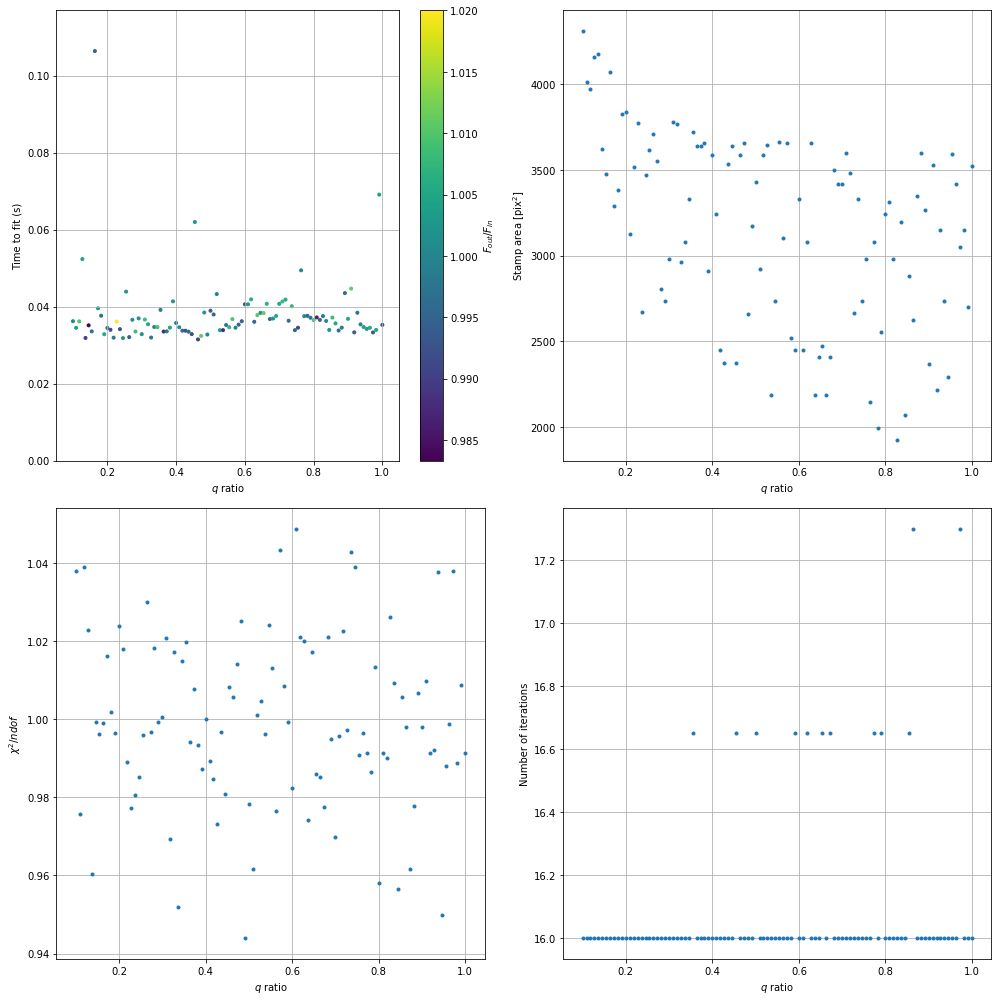

In [24]:
summary_plots(q_ratio,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),np.mean(df0_arr,axis=1),np.mean(nev_arr,axis=1),'$q$ ratio')

# Testing Gaussian noise instead of Poisson noise to see if $\chi^{2} \approx 1$

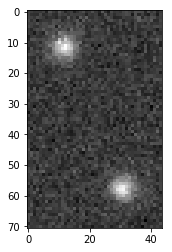

In [25]:
npoints=100
nreps=20
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
nev_arr = np.zeros((npoints,nreps))
df0_arr = np.zeros((npoints,nreps))
df1_arr = np.zeros((npoints,nreps))
q_ratio = np.linspace(0.1,1,npoints)
show=False
for j in range(nreps):
    for i in range(npoints):
        if (j==nreps-1) & (i==npoints-1):
            show=True
        t_arr[i], s_arr[i], rchi_arr[i], nev_arr[i,j], df0_arr[i,j], df1_arr[i,j]  = time_two_galaxies(10,0,0,1,0,0,0.5,1,1,q_ratio[i],add_noise_gauss=True,show_stamp=show,seed=npoints*j+i)

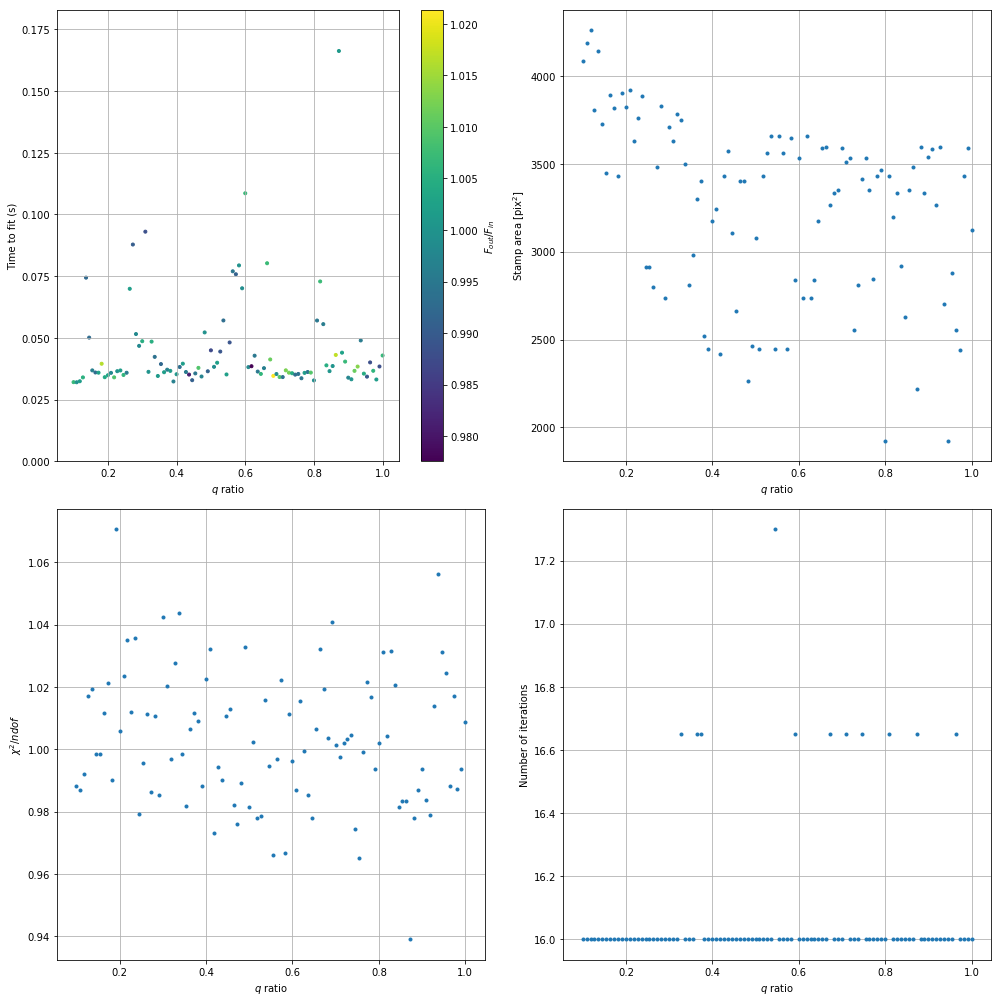

In [26]:
summary_plots(q_ratio,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),np.mean(df0_arr,axis=1),np.mean(nev_arr,axis=1),'$q$ ratio')

# Dependence on orientation (distance=10", mag=24, $\sigma_{-}=0.5"$, $\beta_{0}=0$, $q=0.5$)

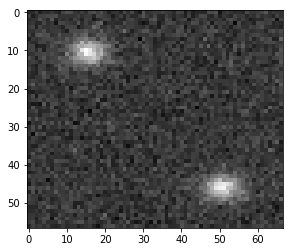

In [27]:
npoints=100
nreps=20
t_arr = np.zeros((npoints,nreps))
s_arr = np.zeros((npoints,nreps))
rchi_arr = np.zeros((npoints,nreps))
nev_arr = np.zeros((npoints,nreps))
df0_arr = np.zeros((npoints,nreps))
df1_arr = np.zeros((npoints,nreps))
beta = np.linspace(-np.pi,np.pi,npoints)
show=False
for j in range(nreps):
    for i in range(npoints):
        if (j==nreps-1) & (i==npoints-1):
            show=True
        t_arr[i], s_arr[i], rchi_arr[i], nev_arr[i,j], df0_arr[i,j], df1_arr[i,j] = time_two_galaxies(10,0,0,1,0,beta[i],0.5,1,0.5,1,add_noise=True,show_stamp=show,seed=npoints*j+i)

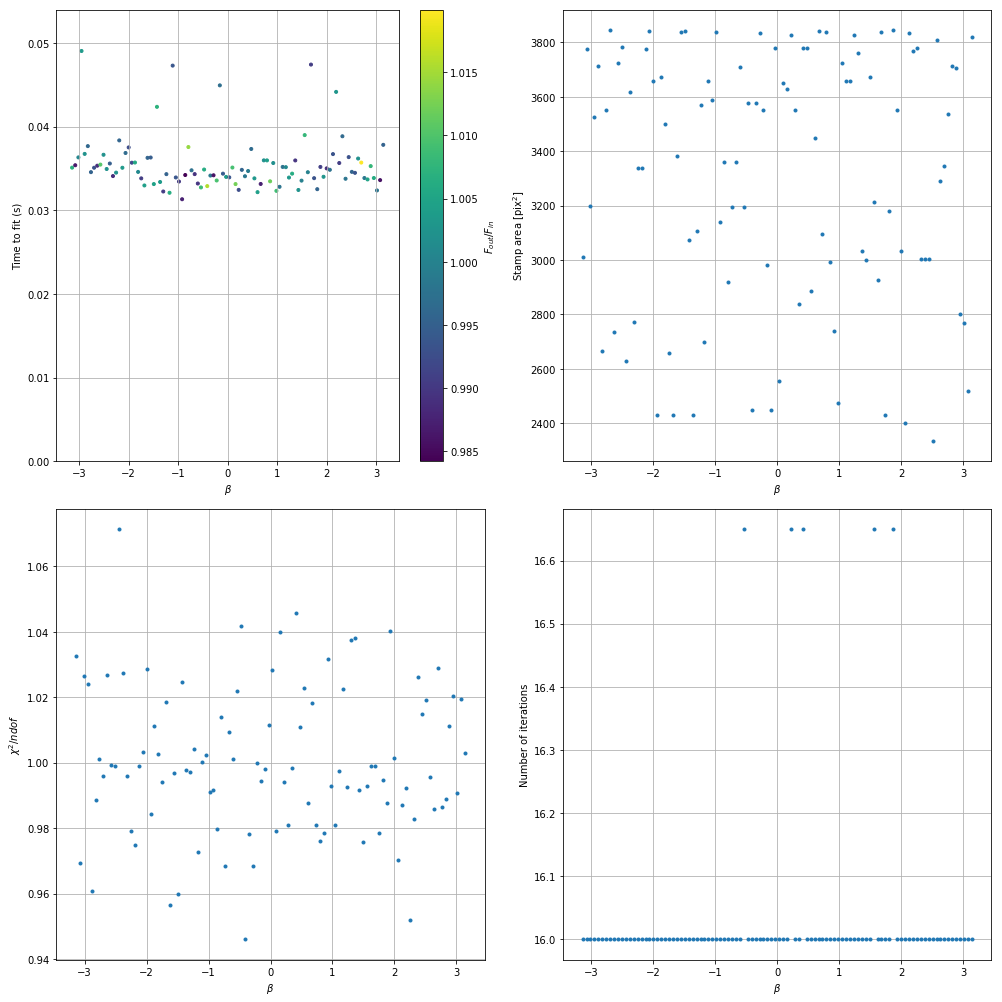

In [28]:
summary_plots(beta,np.mean(t_arr,axis=1),np.mean(s_arr,axis=1),np.mean(rchi_arr,axis=1),np.mean(df0_arr,axis=1),np.mean(nev_arr,axis=1),r'$\beta$')

From these plots it looks like that the overlap between the two sources is the dominant effect increasing the fitting time.

In [80]:
%prun time_two_galaxies(0.01,0,0,1,0,0,0.5,0.5,1,1, add_noise=True)

```ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       17    0.030    0.002    0.031    0.002 gsobject.py:1594(drawFFT_finish)
       17    0.019    0.001    0.020    0.001 gsobject.py:2091(_drawKImage)
       87    0.003    0.000    0.004    0.000 transform.py:123(__init__)
       62    0.002    0.000    0.002    0.000 {method 'reduce' of 'numpy.ufunc' objects}
  924/630    0.002    0.000    0.004    0.000 column.py:710(__setattr__)
       34    0.002    0.000    0.043    0.001 render.py:45(draw)
       17    0.002    0.000    0.050    0.003 analysis.py:667(residuals)
      170    0.002    0.000    0.002    0.000 image.py:1427(_Image)
        2    0.002    0.001    0.004    0.002 asteval.py:72(__init__)
       17    0.001    0.000    0.004    0.000 gsobject.py:1546(drawFFT_makeKImage)
     2840    0.001    0.000    0.001    0.000 {isinstance}
      278    0.001    0.000    0.002    0.000 parameter.py:613(_getval)
       24    0.001    0.000    0.001    0.000 parameter.py:24(isclose)
     1824    0.001    0.000    0.001    0.000 {hasattr}
       17    0.001    0.000    0.063    0.004 gsobject.py:977(drawImage)
       20    0.001    0.000    0.001    0.000 image.py:242(__init__)
        2    0.001    0.001    0.033    0.016 render.py:200(render_galaxy)
      634    0.001    0.000    0.001    0.000 image.py:465(bounds)
      116    0.001    0.000    0.002    0.000 image.py:578(subImage)
      778    0.001    0.000    0.001    0.000 asteval.py:104(<genexpr>)
       17    0.001    0.000    0.052    0.003 minimizer.py:333(__residual)
       34    0.001    0.000    0.001    0.000 compound.py:351(__init__)
       38    0.001    0.000    0.001    0.000 image.py:1524(Image_iadd)```